In [1]:
#export
import os
import pickle
from dataclasses import dataclass
import enum

import cv2
from dataclasses_json import dataclass_json
import ffmpeg
from IPython.display import Image
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize
import skvideo.io
from tqdm import tqdm
from tqdm.contrib.logging import logging_redirect_tqdm


from experiment_utils.constants import *
from experiment_utils.utils import getLogger

In [2]:
logger = getLogger()

In [3]:
def get_sample_videos_paths():
    clips_dir = os.path.join(DATA_DIR, 'clips')
    return [os.path.join(clips_dir, name) for name in os.listdir(clips_dir)]

In [4]:
all_vids = get_sample_videos_paths()

In [5]:
def get_video_size(filename):
    logger.info('Getting video size for {!r}'.format(filename))
    probe = ffmpeg.probe(filename)
    video_info = next(s for s in probe['streams'] if s['codec_type'] == 'video')
    width = int(video_info['width'])
    height = int(video_info['height'])
    
    return width, height

def get_video_num_frames(filename):
    logger.info('Getting video size for {!r}'.format(filename))
    probe = ffmpeg.probe(filename)
    video_info = next(s for s in probe['streams'] if s['codec_type'] == 'video')
    
    return int(video_info['nb_frames'])

In [6]:
%%time
# get_all_frames(all_vids[0])

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


## Downsampling

Since the data in it's original format is approx 32G in size, we need to downsample

We can downsample in multiple ways:

1. Framerate
2. Color
3. Frame Size

In [25]:
class ColorSpace(str, enum.Enum):
    RGB = "RGB"
    BW = "BW"

@dataclass
class DownsampleConfig:
    height: int
    width: int
    fps_ratio: int
    col_space: ColorSpace
        
    __MAGIC = 'downsample_'
    
    def __str__(self):
        return f'{self.__MAGIC}_{self.width}x{self.height}_{self.fps_ratio}_{self.col_space}'
    
    @classmethod
    def from_str(cls, downsample_str: str):
        if downsample_str[:len(cls.__MAGIC)] != cls.__MAGIC:
            raise ValueError("Could not create DownsampleConfig from string: " + downsample_str)
        
        width, *rest = downsample_str[len(cls.__MAGIC):].split('x')
        fields = rest[0].split('_')
        
        height, fps_ratio, col_space, *rest = fields
        
        return DownsampleConfig(height=int(height),
                                width=int(width),
                                fps_ratio=int(fps_ratio),
                                col_space=ColorSpace(col_space))

In [26]:
def get_downsampled_frames(input_filename: str, downsample_config: DownsampleConfig) -> np.array:
    videogen = skvideo.io.vreader(input_filename)
    
    frames = []
    
    with tqdm(total=get_video_num_frames(input_filename)) as progress_bar:
        for frame in videogen:
            if progress_bar.last_print_n % downsample_config.fps_ratio != 0:
                progress_bar.update(1)
                continue
            
            resized_image = resize(frame, (downsample_config.height, downsample_config.width))
            
            if downsample_config.col_space == ColorSpace.BW:
                rgb_weights = [0.2989, 0.5870, 0.1140]
                grayscale_image = np.dot(resized_image[...,:3], rgb_weights)
                int_frame = (grayscale_image * 255).astype(np.uint8)
            else:
                int_frame = (resized_image * 255).astype(np.uint8)
            
            frames.append(int_frame)
            progress_bar.update(1)
    
    return frames

In [27]:
downsampled_frames = get_downsampled_frames(all_vids[1], DownsampleConfig.from_str('downsample_640x480_60_RGB'))

[INFO] 2021-10-17 14:21:19,263 root        : Getting video size for '/mnt/batch/tasks/shared/LS_root/mounts/clusters/experiment-instance0/code/Users/shikharbhardwaj68/csgo-clips-autotrim/data/clips/Counter-strike  Global Offensive 2021.03.11 - 02.34.45.06.DVR.mp4'
100%|██████████| 7212/7212 [01:01<00:00, 116.68it/s]


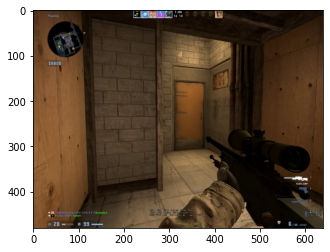

In [28]:
plt.imshow(downsampled_frames[0])

In [ ]:
with open(os.path.join(DATA_DIR, f'downsample_1v4.mp4.pickle'), 'wb') as f:
    pickle.dump(data, f)

In [ ]:
plt.imshow(downsampled_frames[0], cmap='gray')

In [ ]:
data.shape